[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/moshi4/pyCirclize/blob/main/docs/comparative_genomics.ipynb)

In [1]:
# !pip install pycirclizely pygenomeviz
# !apt install ncbi-blast+ mummer mmseqs2

Advanced users can plot figures for comparative genomics flexibly with pyCirclize API.
In this notebook, simple code recipes for comparative genomics Circos visualization utilizing [pyGenomeViz](https://github.com/moshi4/pyGenomeViz) align module are shown.  

## MUMmer

Plot MUMmer alignment links between query-reference genomes.

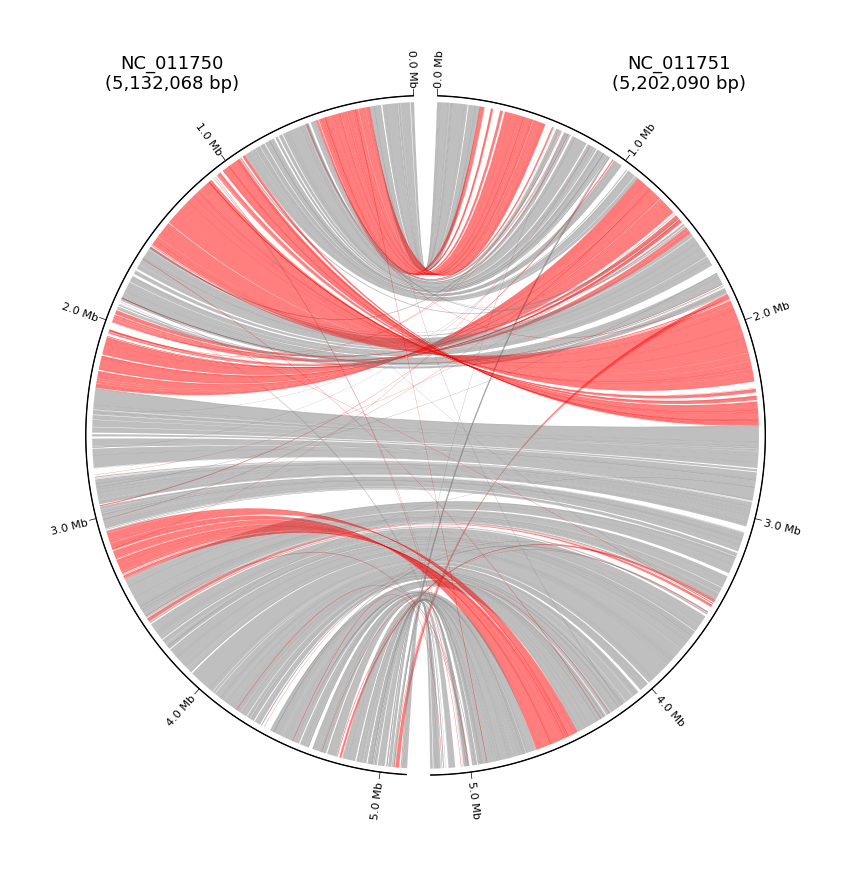

In [2]:
from pygenomeviz.align import MUMmer
from pygenomeviz.parser import Genbank
from pygenomeviz.utils import load_example_genbank_dataset

from pycirclizely import Circos

TICKS_INTERVAL = 1000000

# Load query & reference genbank files
gbk_files = load_example_genbank_dataset("escherichia_coli")
ref_gbk = Genbank(gbk_files[2])
query_gbk = Genbank(gbk_files[3])

# Initialize circos instance
circos = Circos(
    sectors=dict(
        **ref_gbk.get_seqid2size(),
        **dict(reversed(list(query_gbk.get_seqid2size().items()))),
    ),
    start=-358,
    end=2,
    space=4,
    sector2clockwise={seqid: False for seqid in query_gbk.get_seqid2size().keys()},
)
circos.text(
    f"{ref_gbk.name}\n({ref_gbk.full_genome_length:,} bp)", r=130, deg=35, size=13
)
circos.text(
    f"{query_gbk.name}\n({query_gbk.full_genome_length:,} bp)", r=130, deg=-35, size=13
)

# Plot genomic sector axis & xticks
for sector in circos.sectors:
    track = sector.add_track((99.8, 100))
    track.axis(fc="black")
    if sector.size >= TICKS_INTERVAL:
        track.xticks_by_interval(
            TICKS_INTERVAL,
            label_formatter=lambda v: f"{v/1000000:.1f} Mb",
            label_orientation="vertical",
        )

# MUMmer genome comparison & plot links
align_coords = MUMmer([query_gbk, ref_gbk]).run()
for ac in align_coords:
    region1 = (ac.query_name, ac.query_start, ac.query_end)
    region2 = (ac.ref_name, ac.ref_start, ac.ref_end)
    color = "red" if ac.is_inverted else "grey"
    circos.link(region1, region2, color=color, r1=98, r2=98)

fig = circos.plotfig()

## MMseqs

Search RBH(Reciprocal Best Hit) CDSs and plot hit links between query-reference genomes by MMseqs.

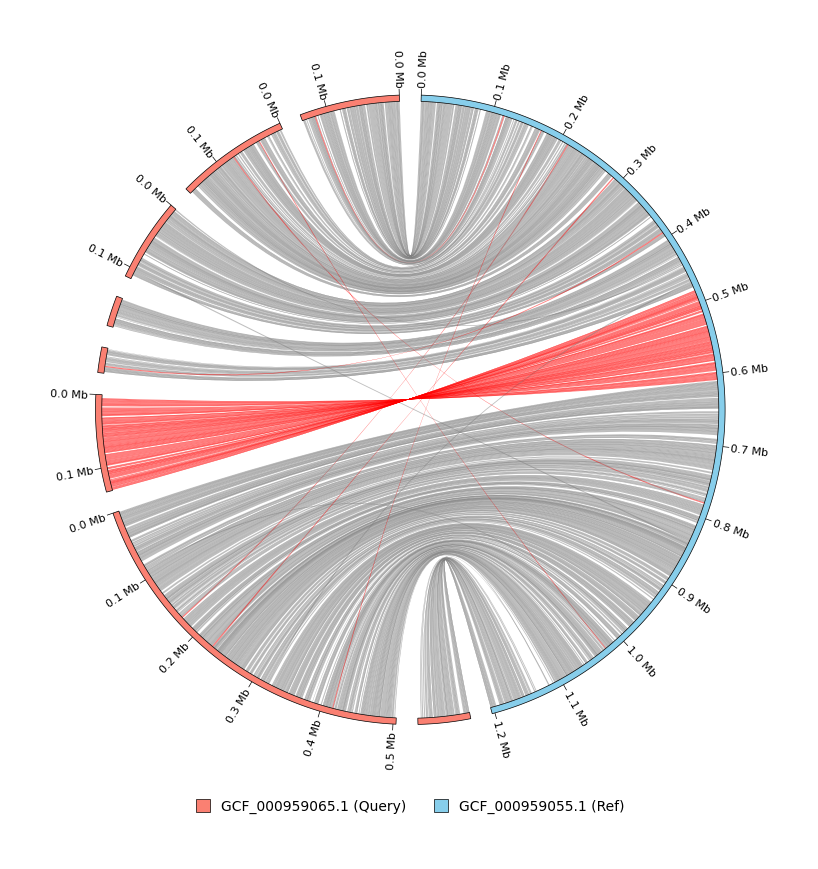

In [3]:
from matplotlib.patches import Patch
from pygenomeviz.align import MMseqs
from pygenomeviz.parser import Genbank
from pygenomeviz.utils import load_example_genbank_dataset

from pycirclizely import Circos

QUERY_COLOR = "salmon"
REF_COLOR = "skyblue"
TICKS_INTERVAL = 100000

# Load query & reference genbank files
gbk_files = load_example_genbank_dataset("mycoplasma_mycoides")
query_gbk = Genbank(gbk_files[3])
ref_gbk = Genbank(gbk_files[2])

# Initialize circos instance
circos = Circos(
    sectors=dict(
        **ref_gbk.get_seqid2size(),
        **dict(reversed(list(query_gbk.get_seqid2size().items()))),
    ),
    start=-358,
    end=2,
    space=4,
    sector2clockwise={seqid: False for seqid in query_gbk.get_seqid2size()},
)

# Plot genomic sector axis & xticks
for sector in circos.sectors:
    track = sector.add_track((98, 100))
    color = QUERY_COLOR if sector.name in query_gbk.get_seqid2size() else REF_COLOR
    track.axis(fc=color)
    if sector.size >= TICKS_INTERVAL:
        track.xticks_by_interval(
            TICKS_INTERVAL,
            label_formatter=lambda v: f"{v/1000000:.1f} Mb",
            label_orientation="vertical",
        )

# Search MMseqs RBH CDSs & plot hit links
align_coords = MMseqs([query_gbk, ref_gbk]).run()
for ac in align_coords:
    region1 = (ac.query_name, ac.query_start, ac.query_end)
    region2 = (ac.ref_name, ac.ref_start, ac.ref_end)
    color = "red" if ac.is_inverted else "grey"
    circos.link(region1, region2, color=color)

fig = circos.plotfig()

# Plot legend
_ = circos.ax.legend(
    handles=[
        Patch(label=f"{query_gbk.name} (Query)", fc=QUERY_COLOR, ec="black", lw=0.5),
        Patch(label=f"{ref_gbk.name} (Ref)", fc=REF_COLOR, ec="black", lw=0.5),
    ],
    loc="center",
    bbox_to_anchor=(0.5, -0.1),
    ncols=2,
)

## Blast

Plot [BRIG](https://doi.org/10.1186/1471-2164-12-402)(Blast Ring Image Generator) like genome comparison figure.

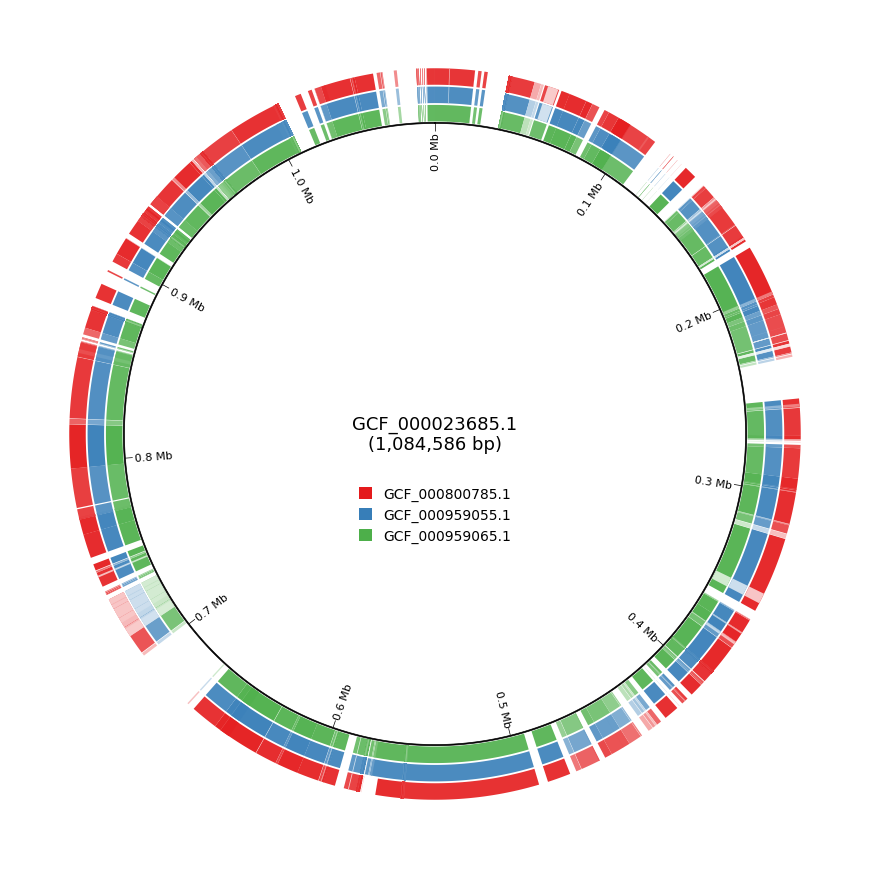

In [4]:
from matplotlib.patches import Patch
from pygenomeviz.align import AlignCoord, Blast
from pygenomeviz.parser import Fasta
from pygenomeviz.utils import ColorCycler, interpolate_color, load_example_fasta_dataset

from pycirclizely import Circos

ColorCycler.set_cmap("Set1")

QUERY_TRACK_SIZE = 5
MIN_IDENTITY = 70
TICKS_INTERVAL = 100000

# Load target & comparison fasta files
fasta_files = load_example_fasta_dataset("mycoplasma_mycoides")
target_fasta = Fasta(fasta_files[0])
comp_fasta_list = list(map(Fasta, fasta_files[1:]))

# Initialize circos instance
circos = Circos(
    sectors=target_fasta.get_seqid2size(),
    space=0 if len(target_fasta.get_seqid2size()) == 1 else 2,
)
circos.text(f"{target_fasta.name}\n({target_fasta.full_genome_length:,} bp)", size=13)

# Blast genome comparison & plot match blocks
min_r_pos = 100
comp_name2color = {}
for idx, comp_fasta in enumerate(comp_fasta_list):
    align_coords = Blast([target_fasta, comp_fasta]).run()
    align_coords = AlignCoord.filter(align_coords, identity_thr=MIN_IDENTITY)
    color = ColorCycler()
    comp_name2color[comp_fasta.name] = color
    min_r_pos -= QUERY_TRACK_SIZE
    for sector in circos.sectors:
        sector.add_track((min_r_pos, min_r_pos + QUERY_TRACK_SIZE), r_pad_ratio=0.1)
    for ac in align_coords:
        track = circos.get_sector(ac.query_name).tracks[
            -1
        ]  # Last added track in sector
        rect_color = interpolate_color(color, v=ac.identity, vmin=MIN_IDENTITY)  # type: ignore
        track.rect(ac.query_start, ac.query_end, color=rect_color)

# Plot genomic sector axis & xticks
for sector in circos.sectors:
    track = sector.add_track((min_r_pos - 0.3, min_r_pos))
    track.axis(fc="black")
    if sector.size >= TICKS_INTERVAL:
        track.xticks_by_interval(
            TICKS_INTERVAL,
            outer=False,
            label_formatter=lambda v: f"{v/1000000:.1f} Mb",
            label_orientation="vertical",
        )

fig = circos.plotfig()

# Plot legend
_ = fig.legend(
    handles=[
        Patch(label=query_name, fc=color)
        for query_name, color in comp_name2color.items()
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, 0.45),
)